# Mechanisms of Action (MoA) Prediction

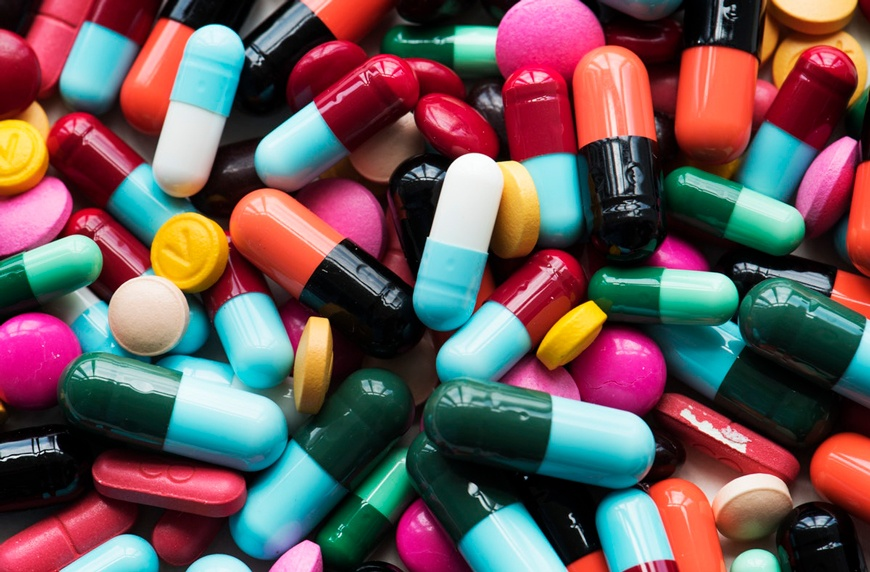

In this notebook we will explore the data provided for the competition and create a baseline LGBM  model.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Competition General Description
Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target.



In this dataset we have information about one of the approaches: sample of human cells is treated with the drug and then scientists analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.



# Evaluation Metric Used : Log Loss
 
For every sig_id you will be predicting the probability that the sample had a positive response for each target. For N sig_id rows and M targets, you will be making N×M predictions. Submissions are scored by the log loss:



# **Data Loading**

In [ ]:
os.listdir('../input/lish-moa')

In [ ]:
train_features = pd.read_csv("../input/lish-moa/train_features.csv")
test_features = pd.read_csv("../input/lish-moa/test_features.csv")
submission = pd.read_csv("../input/lish-moa/sample_submission.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")

Glancing Through Training and Test sets 

In [ ]:
train_features.head()

In [ ]:

print(f" The Shape of training set : {train_features.shape}")
print(f" The number of training examples are : {train_features.shape[0]}")
print(f" Independent Features availble in training set  : {train_features.shape[-1]}")

In [ ]:
test_features.head()

In [ ]:
print(f" The Shape of test set : {test_features.shape}")
print(f" The number of test examples are : {test_features.shape[0]}")
print(f" Independent Features availble in test set  : {test_features.shape[-1]}")

In [ ]:
# The scored Training Targets 
train_targets_scored.head()

In [ ]:
train_targets_nonscored.head()

In [ ]:
# Lets Checkout the sample Submission File
submission.head()

In [ ]:
print(f"The format for predicting the data is of shape : {submission.shape}" )
print(f"The sample Output Data given for {submission.shape[0]} examples")

Lets Check the DataType of Columns in Train and Test Set :

In [ ]:
train_features.info()
print('______________________________')
test_features.info()
print('______________________________')
train_targets_scored.info()
print('______________________________')
train_targets_nonscored.info()

* *We could see that in training Set : **872** Features are of Float Dtype , **1** feature of Int Dtype & **3** Categorical Dtype*

* *We could see that in Test Set : **872** Features are of Float Dtype , **1** feature of Int Dtype & **3** Categorical Dtype*

* *We could see that in Scored Target Set : **0** Features are of Float Dtype , **402** feature of Int Dtype & **1 **Categorical Dtype*

* *We could see that in training Set : **0** Features are of Float Dtype ,** 206** feature of Int Dtype &** 1** Categorical Dtype*

Lets Checkout the Samples with Zero Targets :

cp_type : control perturbations have no MoAs

# Visualization of Categories 

The 3 categorical Variables are :

1. cp_type : indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle)

2. sig_id : Unique Individual ID's

3. cp_dose : Dose(low,high)

The One Integer Feature is :

1. cp_time : This indicates treatment Duration(24,48,72) hours

In [ ]:
train_features.cp_type.value_counts(normalize=True)


In [ ]:
control_group = train_features.loc[train_features.cp_type == 'ctl_vehicle', 'sig_id']
print(f" The control Value has {train_targets_scored.loc[train_targets_scored['sig_id'].isin(control_group)].sum()[1:].sum()} values in Targets")

So this rows wont help us in the prediction so not using them for training should suffice the problem

In [ ]:
train_features.cp_time.value_counts(normalize=True)


In [ ]:
train_features.cp_dose.value_counts(normalize=True)


In [ ]:
test_features.cp_type.value_counts(normalize=True)


In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('seaborn-dark')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
%matplotlib inline

# 1. **CP_Type Feature :**

In [ ]:
# Lets just Concat the train and test dataframe for the (CP) features :
df = pd.concat([train_features,test_features])
train_features['kf'] = 'train'
test_features['kf'] = 'test'

In [ ]:
import seaborn as sns
sns.countplot(df['cp_time'])

We could see that ( cp_time ) time duration for 3 classes (24,28,72) is approximately same

In [ ]:
sns.countplot(df['cp_type'])

cp_type is skewed with large quantity of trt_cp over small quantity of ctl_vehicle. 

SO lets Check this skewed distribution over in train and test set individually .

In [ ]:
fig,ax= plt.subplots(1,2)
sns.countplot(train_features['cp_type'],ax=ax[0])
sns.countplot(test_features['cp_type'],ax=ax[1])

In [ ]:
sns.countplot(df['cp_dose'])

In [ ]:
import plotly.express as px
ds = df.groupby(['cp_type', 'kf'])['sig_id'].count().reset_index()
ds.columns = ['cp_type', 'kf', 'count']
fig = px.bar(
    ds, 
    x='cp_type', 
    y="count", 
    color = 'kf',
    barmode='group',
    orientation='v', 
    title='cp_type train+test counts', 
    width=700,
    height=500
)
fig.show()


In [ ]:
ds = df.groupby(['cp_dose', 'kf'])['sig_id'].count().reset_index()
ds.columns = ['cp_dose', 'kf', 'count']
fig = px.bar(
    ds, 
    x='cp_dose', 
    y="count", 
    color = 'kf',
    barmode='group',
    orientation='v', 
    title='cp_dose train+test counts', 
    width=600,
    height=500
)
fig.show()

Columns with Lower number of Positive Samples :

In [ ]:
data = train_targets_scored.drop(['sig_id'], axis=1).astype(bool).sum(axis=1).reset_index()
data.columns = ['row', 'count']
data = data.groupby(['count'])['row'].count().reset_index()
fig = px.pie(
    data, 
    values=100 * data['row']/len(train_targets_scored), 
    names="count", 
    title='Activations in targets for every sample Percentage ', 
    width=800, 
    height=500
)
fig.show()

We could see biggest number of Postive samples for Category 1

# Target to be Predicted :

In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

In [ ]:
x = train_targets_scored.drop(['sig_id'], axis=1).sum(axis=0).sort_values(ascending=False).reset_index()
x.columns = ['column', 'nonzero_records']

fig = px.bar(
    x.tail(50), 
    x='nonzero_records', 
    y='column', 
    orientation='h', 
    title='Columns with the lowest number of positive samples (top 50)', 
    height=1000, 
    width=800
)
fig.show()

In [ ]:
ax = train_targets_scored.drop('sig_id', axis=1) \
    .sum() \
    .sort_values(ascending=False) \
    .head(30) \
    .sort_values() \
    .plot(kind='barh',
         figsize=(15, 10),
          color=next(color_cycle)
         )
ax.set_title('Top 30  Targets in Train Set', fontsize=20)
plt.show()

The most scored Target in Train : nfkb_inhibitor , proteasome_inhibator

# Baseline :

Lets use LightGBM as our Baseline

In [ ]:
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
warnings.simplefilter('ignore')
sns.set()
import random
%matplotlib inline

In [ ]:
train_features['cp_type'].value_counts

In [ ]:
'''
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from category_encoders import CountEncoder
'''

# Configs :

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything(seed=42)

params = {'num_leaves': 500,
          'min_child_weight': 0.03,
          'feature_fraction': 0.3,
          'bagging_fraction': 0.4,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'binary_logloss',
          "verbosity": 0,
          'reg_alpha': 0.4,
          'reg_lambda': 0.6,
          'random_state': 47
         }


# Preprocessing of Categorical Variables :


In [ ]:
for feature in ['cp_type', 'cp_dose']:
    trans = LabelEncoder()
    trans.fit(list(train_features[feature].astype(str).values) + list(test_features[feature].astype(str).values))
    train_features[feature] = trans.transform(list(train_features[feature].astype(str).values))
    test_features[feature] = trans.transform(list(test_features[feature].astype(str).values))

In [ ]:
train_features.drop('kf',axis=1,inplace=True)

In [ ]:
test_features.drop('kf',axis=1,inplace=True)

In [ ]:

features = [x for x in train_features.columns if x != 'sig_id']
print(len(features))

In [ ]:
targets = [x for x in train_targets_scored.columns if x != 'sig_id']
print(f'Total Labels available :{len(targets)}')

In [ ]:
X=train_features[features]
total_loss = 0

# Cross Validation :

Lets use Stratified k-fold

In [ ]:
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

We are creating baseline Model using LightGBM and framing our problem as n-binary classification problem. 

In [ ]:
print(f" The number of Models to be created are : {train_targets_scored.shape[-1]-1}")
print(" This is equal to the number of Labels we have")

In [ ]:

for model,target in enumerate(targets,1):
    y = train_targets_scored[target]
    predictions = np.zeros(test_features.shape[0])
    oof_preds = np.zeros(X.shape[0])
    
    for train_idx, test_idx in skf.split(X, y):
        train_data = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, train_data, 10000, valid_sets = [train_data, val_data], verbose_eval=0, early_stopping_rounds=30)
        oof_preds[test_idx] = clf.predict(X.iloc[test_idx])
        predictions += clf.predict(test_features[features]) / skf.n_splits
        
    submission[target] = predictions
    loss = log_loss(y, oof_preds)
    total_loss += loss
    
    print(f"Model:{model} ==> Losses:{loss:.4f}")

    del predictions, oof_preds,  y, loss
    gc.collect();
    

# GPU for GBM
Params to be Changed to  use GPU to Accelerate the LGBM: 
1.  'device': 'gpu',
2. 'gpu_platform_id': 0,
1. 3.   'gpu_device_id': 0

In [ ]:
print('Overall mean loss: {:.3f}'.format(total_loss / 206))


In [ ]:
submission.to_csv('submission.csv', index=False)

Next Boosting Model to Tryout would be XG-Boost !!!

In [ ]:
print("Visualizing the predictions made ")
temp = pd.read_csv("./submission.csv")
temp.head()

* Thanks a lot for Reading the kernal . Hope you found the Kernal Helpful !!!

* Eager for Suggestions and making improvements !! 